In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Getting the data

In [2]:
data = pd.read_csv("housing.csv")
data = pd.DataFrame(data)
data.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


## Filling null values

In [3]:
mean_value_total_bedrooms = data['total_bedrooms'].mean()
mean_value_total_bedrooms = round(mean_value_total_bedrooms)
mean_value_total_bedrooms

538

In [4]:
null_bedrooms = [] 
for key,value in enumerate(data['total_bedrooms']):
     if pd.isnull(value):
         null_bedrooms.append(key)


In [5]:
data.loc[null_bedrooms,'total_bedrooms'] = mean_value_total_bedrooms
data = pd.DataFrame(data)
data.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


# One Hot Encoding

In [6]:
encoded_data = pd.get_dummies(data['ocean_proximity']).astype(int) 
data.drop('ocean_proximity', axis=1,inplace=True)
data = pd.concat([data,encoded_data], axis=1)
data = data.rename(columns={'<1H OCEAN' : '1H OCEAN'})

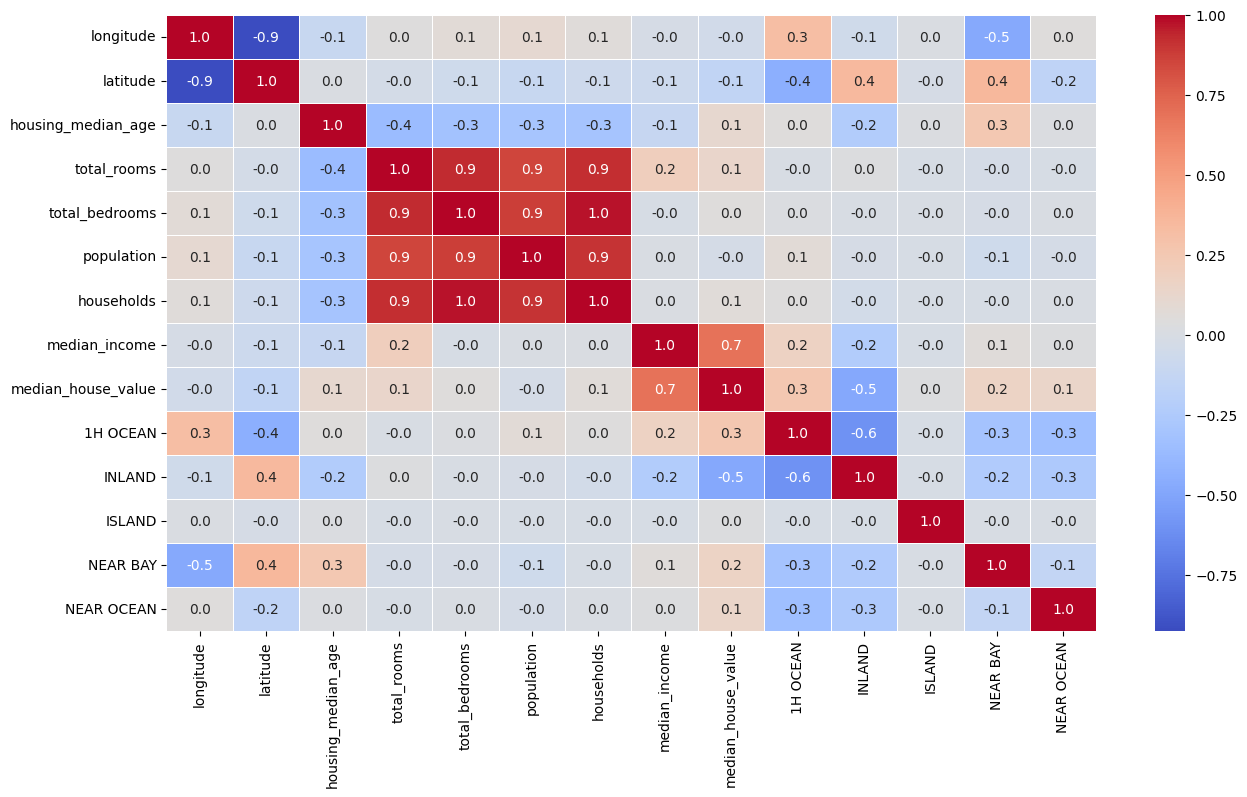

In [7]:
correlation_matrix  = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix,annot=True,fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.show()

## Feature Engineering

In [8]:
data['avg_bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']
data.drop(['total_rooms','total_bedrooms','population','households'],axis=1, inplace=True)

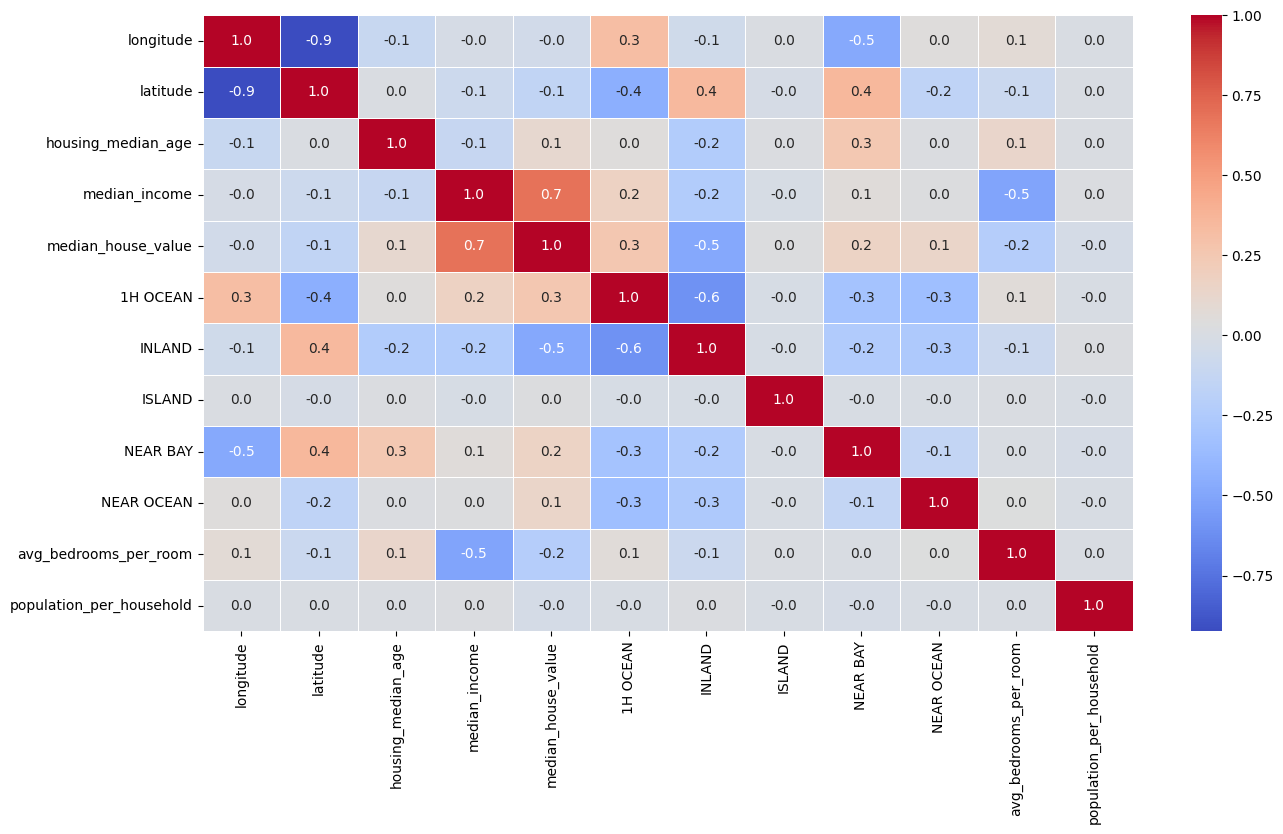

In [9]:
new_corr = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(new_corr,annot=True,fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.show()

## Removing outliers

In [10]:
def remove_outliers(data):
    clean_data = data.copy()  # Original data copy to preserve it !
    
    for _ in range(3):
        for column in clean_data.columns:
            q1 = np.percentile(clean_data[column], 25)
            q3 = np.percentile(clean_data[column], 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            # Removing outliers from clean_data
            clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]
    
    return clean_data

new_data = remove_outliers(data)
print(new_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13111 entries, 830 to 20639
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 13111 non-null  float64
 1   latitude                  13111 non-null  float64
 2   housing_median_age        13111 non-null  float64
 3   median_income             13111 non-null  float64
 4   median_house_value        13111 non-null  float64
 5   1H OCEAN                  13111 non-null  int32  
 6   INLAND                    13111 non-null  int32  
 7   ISLAND                    13111 non-null  int32  
 8   NEAR BAY                  13111 non-null  int32  
 9   NEAR OCEAN                13111 non-null  int32  
 10  avg_bedrooms_per_room     13111 non-null  float64
 11  population_per_household  13111 non-null  float64
dtypes: float64(7), int32(5)
memory usage: 1.1 MB
None


In [11]:
column_names = new_data.columns 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_data)
scaled_data=pd.DataFrame(scaled_data, columns=column_names)


# Modeling

In [12]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

x = scaled_data.drop(['median_house_value'], axis = 1)
y= scaled_data['median_house_value'] 

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

# XGBRegressor with RandomizedSearchCV

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


param_dist = {
    'n_estimators': randint(50, 300),  
    'learning_rate': uniform(0.01, 0.5),  
    'max_depth': randint(3, 10),  
    'min_child_weight': randint(1, 10),  
    'subsample': uniform(0.6, 0.4), 
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),  
    'reg_alpha': uniform(0, 1),  # L1 
    'reg_lambda': uniform(0, 1)  # L2 
}

# XGBRegressor model
xgb = XGBRegressor()

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)

print("Best Parameters ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Best Parameters  {'colsample_bytree': 0.6301738188359077, 'gamma': 0.16621543190925292, 'learning_rate': 0.1184045532932456, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 166, 'reg_alpha': 0.6969250558638148, 'reg_lambda': 0.3842018313792199, 'subsample': 0.8948402823372077}
Best Score:  0.8384105125427199


In [14]:

best_model = random_search.best_estimator_

y_pred = best_model.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print(r2)

Mean Squared Error: 0.16135816291898045
0.83366941955623


# Random Forest Regressor with RandomizedSearchCV

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor()
rf.fit(x_train,y_train)
new_pred = rf.predict(x_test)
r2_rf = r2_score(y_test, new_pred)
print(r2_rf)

0.804155807507321


In [17]:
param_dist_rf = {
    'n_estimators': randint(10,300),
    'max_features' : randint(1,20),
    'max_depth': randint(1,10)
}

random_forest = RandomizedSearchCV(rf, param_distributions= param_dist_rf )
random_forest.fit(x_train,y_train)
print("Best params ", random_forest.best_params_)
print("Best Score ", random_forest.best_score_)


Best params  {'max_depth': 8, 'max_features': 6, 'n_estimators': 281}
Best Score  0.7791416496575945


In [18]:
rf_pred = random_forest.predict(x_test)
r2_random = r2_score(y_test,rf_pred)
print(r2_random)

0.7720126119437501


## Catboost with RandomizedSearchCV

In [19]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor()
cat.fit(x_train,y_train)
cat_pred = cat.predict(x_test)
r2_cat = r2_score(y_test,cat_pred)
print(r2_cat)

Learning rate set to 0.059354
0:	learn: 0.9663163	total: 138ms	remaining: 2m 18s
1:	learn: 0.9317971	total: 142ms	remaining: 1m 10s
2:	learn: 0.8995961	total: 145ms	remaining: 48.2s
3:	learn: 0.8701922	total: 151ms	remaining: 37.5s
4:	learn: 0.8424468	total: 156ms	remaining: 31s
5:	learn: 0.8169648	total: 159ms	remaining: 26.4s
6:	learn: 0.7940080	total: 162ms	remaining: 23s
7:	learn: 0.7726133	total: 167ms	remaining: 20.7s
8:	learn: 0.7532948	total: 170ms	remaining: 18.7s
9:	learn: 0.7364551	total: 173ms	remaining: 17.1s
10:	learn: 0.7198465	total: 175ms	remaining: 15.8s
11:	learn: 0.7030168	total: 178ms	remaining: 14.7s
12:	learn: 0.6885295	total: 185ms	remaining: 14.1s
13:	learn: 0.6763759	total: 188ms	remaining: 13.2s
14:	learn: 0.6642840	total: 191ms	remaining: 12.5s
15:	learn: 0.6529122	total: 194ms	remaining: 11.9s
16:	learn: 0.6429480	total: 198ms	remaining: 11.5s
17:	learn: 0.6324801	total: 201ms	remaining: 11s
18:	learn: 0.6246344	total: 203ms	remaining: 10.5s
19:	learn: 0.61

In [ ]:
param_dist_cat = {
    'iterations': randint(250,300),  
    'learning_rate': [0.1,0.3,0.7],  
    'depth': [10,12,14], 
    'l2_leaf_reg': [10,12,15], 
    'loss_function': ['RMSE'], 
    'eval_metric': ['R2'],  
    'verbose': [False] 
}


random_cat = RandomizedSearchCV(cat, param_distributions=param_dist_cat, n_jobs=-1)
random_cat.fit(x_train,y_train)


In [ ]:
print(random_cat.best_params_)

In [ ]:
best_cat = random_cat.best_estimator_
best_cat_pred = best_cat.predict(x_test)
best_cat_score = r2_score(y_test,best_cat_pred)
print(best_cat_score)

# Support Vector Regression with RandomizedSearchCV

In [25]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(x_train,y_train)

SVR()

In [26]:
svr_pred = svr.predict(x_test)
svr_r2 = r2_score(y_test,svr_pred)
print(svr_r2)

0.7656516600056165


In [27]:
param_dist_svr = {
    'C': randint(1, 100), 
    'epsilon': [0.1, 0.2, 0.3],  
    'gamma': ['scale', 'auto'],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  
}


random_svr = RandomizedSearchCV(svr, param_distributions=param_dist_svr)
random_svr.fit(x_train,y_train)


RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000014010907A60>,
                                        'epsilon': [0.1, 0.2, 0.3],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']})

In [30]:
print(random_svr.best_params_)

{'C': 36, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [29]:
svr_random_pred = random_svr.predict(x_test)
svr_random_r2 = r2_score(y_test,svr_random_pred)
print(svr_random_r2)

0.7755547493837517


# GradientBoostingRegressor with RandomizedSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


param_dist_gb = {
    'n_estimators': randint(100,300),
    'learning_rate': [0.1,0.3,0.7], 
    'max_depth': [3, 5, 7],  
    'min_samples_split': [10,12,15],  
    'min_samples_leaf': [1, 2, 4], 
    'subsample': [0.8, 0.9,1.0],
}

gb_regressor = GradientBoostingRegressor()

gb_regressor= RandomizedSearchCV(gb_regressor, param_distributions=param_dist_gb)
gb_regressor.fit(x_train, y_train)

# Modeli test verisi üzerinde değerlendirelim
y_pred_gb = gb_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred_gb)
print("Mean Squared Error:", mse)
gb_regressor_r2 = r2_score(y_test, y_pred_gb)
print(gb_regressor_r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


param_dist_gb = {
    'n_estimators': randint(100,300),
    'learning_rate': [0.1,0.3], 
    'max_depth': [7,9,11],  
    'min_samples_split': [10,12,15],  
    'min_samples_leaf': [1, 2, 4], 
    'subsample': [1.0],
}

gb_regressor = GradientBoostingRegressor()

gb_regressor= RandomizedSearchCV(gb_regressor, param_distributions=param_dist_gb, n_jobs = -1)
gb_regressor.fit(x_train, y_train)

# Modeli test verisi üzerinde değerlendirelim
y_pred_gb = gb_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred_gb)
print("Mean Squared Error:", mse)
gb_regressor_r2 = r2_score(y_test, y_pred_gb)
print(gb_regressor_r2)

In [ ]:
print(gb_regressor.best_params_)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4)  
x_train_poly = poly_features.fit_transform(x_train)

lin_reg = LinearRegression()
lin_reg.fit(x_train_poly, y_train)

# Eğitim seti üzerinde tahmin yapma
y_train_predict = lin_reg.predict(x_train_poly)

# Test seti üzerinde tahmin yapma
x_test_poly = poly_features.transform(x_test)
y_test_predict = lin_reg.predict(x_test_poly)

poly_r2 = r2_score(y_test, y_test_predict)
print(poly_r2)

# KNeighborsRegressor with RandomizedSearchCV

In [92]:
from sklearn.neighbors import KNeighborsRegressor 

knn = KNeighborsRegressor()

param_dist_knn = {
    'n_neighbors': randint(10, 30),
    'weights': ['distance'],  # Distance weights only
    'algorithm': ['auto'],
    'leaf_size': randint(50,200),
    'p': [1],  # Manhattan distance
    'metric': ['manhattan']
}

knn_search = RandomizedSearchCV(knn, param_dist_knn, n_iter=10, cv=5, scoring='r2')
knn_search.fit(x_train, y_train)


best_knn_model = knn_search.best_estimator_

knn_pred = best_knn_model.predict(x_test)

knn_r2 = r2_score(y_test, knn_pred)
print("KNeighborsRegressor R2 Score:", knn_r2)

KNeighborsRegressor R2 Score: 0.7744819650573049


In [93]:
print(knn_search.best_params_)


{'algorithm': 'auto', 'leaf_size': 190, 'metric': 'manhattan', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


## Bagging Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

bag_model = BaggingRegressor(
        estimator = RandomForestRegressor(),
        n_estimators=100,
        max_samples=0.8,
        oob_score=True,
        random_state=0
).fit(x_train,y_train)
bag_model.oob_score_

In [99]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

bag_model = BaggingRegressor(
        estimator = DecisionTreeRegressor(),
        n_estimators=100,
        max_samples=0.8,
        oob_score=True,
        random_state=0
).fit(x_train,y_train)
bag_model.oob_score_

0.8066256827543389

In [111]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

param_bagging_dt = {
    'estimator': [DecisionTreeRegressor()],
    'n_estimators': randint(50, 300),
    'max_samples': [0.5, 0.8, 1],
    'oob_score': [True]
}

bagging_tree = BaggingRegressor()
random_tree = RandomizedSearchCV(bagging_tree, param_bagging_dt, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
random_tree.fit(x_train, y_train)

best_bagging_model = random_tree.best_estimator_

bagging_pred = best_bagging_model.predict(x_test)

bagging_r2 = r2_score(y_test, bagging_pred)
print("BaggingRegressor R2 Score:", bagging_r2)


BaggingRegressor R2 Score: 0.8166353905226186


In [110]:
print(random_tree.best_params_)

{'estimator': DecisionTreeRegressor(), 'max_samples': 0.8, 'n_estimators': 136, 'oob_score': True}


# Saving the model

In [113]:
import pickle
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(cat, file)

# Modeli diskten yükleme
with open('catboost_model.pkl', 'rb') as file:
    loaded_cat = pickle.load(file)

# Tahmin yapma
cat_pred = loaded_cat.predict(x_test)

# R2 skoru hesaplama
r2_cat = r2_score(y_test, cat_pred)
print(r2_cat)

0.8465198328720738
